<a href="https://colab.research.google.com/github/FaddliLWibowo/klasifikasi-gulma/blob/main/Weed_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install livelossplot
!pip install split-folders --upgrade --quiet

In [2]:
import numpy as np
import pandas as pd
import os
import cv2
from PIL import Image
from livelossplot import PlotLossesKerasTF
import splitfolders

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from google.colab import drive
from google.colab import files

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import Input
from keras.models import Model, Sequential, load_model
from keras import layers
from keras import models
from keras.layers import Conv2D, Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout, MaxPool2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator as Imgen
from keras.preprocessing import image
from keras.applications.densenet import DenseNet121
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
#Merubah direktori pada GDrive
%cd /content/gdrive/My Drive/00_Kumpulan_Dataset/Weed-Dataset

/content/gdrive/My Drive/00_Kumpulan_Dataset/Weed-Dataset


In [5]:
#Cek direktori pada saat ini
!pwd

/content/gdrive/My Drive/00_Kumpulan_Dataset/Weed-Dataset


In [6]:
# Menampilkan file
!ls

weed-dataset.zip


In [ ]:
# unzip dataset dari Gdrive, sekaligus remove file zip. kalau data sudah ada maka comment code
# !unzip \*.zip  && rm *.zip
!unzip \*.zip

In [8]:
#Variabel global
IMG_SIZE = 300
BATCH_SIZE = 32
SEED = 123
N_ch=3
Epochs=10
numofClasses=27
accuracyThreshold = 0.98

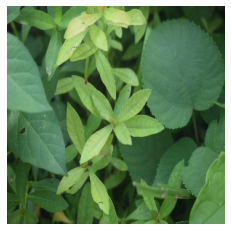

In [9]:
# Menampilkan jenis bunga
img = plt.imread("./weed-dataset/alligatorweed/Alligatorweed (61).JPG")
img = cv2.resize(img,(IMG_SIZE, IMG_SIZE))
plt.imshow(img)
plt.axis("off")
plt.show()

In [10]:
#Menentukan path dataset yang ada di GDrive
BASE_DIR = '/content/gdrive/MyDrive/00_Kumpulan_Dataset/Weed-Dataset/weed-dataset'

In [11]:
# Split folder, kalau data sudah ada maka comment code
splitfolders.ratio(BASE_DIR ,output="new-dataset", seed=42, ratio=(0.8,0.2))

Copying files: 14276 files [02:25, 98.44 files/s] 


In [ ]:
# Hapus Folder, kalau data sudah terhapus maka comment code
# os.removedirs("./new-dataset/train")
# os.removedirs("./new-dataset/val")

In [12]:
# Generate data
train_generator = Imgen(preprocessing_function=keras.applications.densenet.preprocess_input,
                    zoom_range=0.2,
                    shear_range=0.2,
                    rotation_range=360,
                    horizontal_flip=True,
                    vertical_flip=True,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    fill_mode='nearest'
                 )

val_generator = Imgen(preprocessing_function=keras.applications.densenet.preprocess_input,
                    zoom_range=0.2,
                    shear_range=0.2,
                    rotation_range=360,
                    horizontal_flip=True,
                    vertical_flip=True,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    fill_mode='nearest'
                )

In [13]:
# Generate data latih
train_dataset = train_generator.flow_from_directory("./new-dataset/train",
                                          target_size=(IMG_SIZE,IMG_SIZE),
                                          seed = SEED,
                                          batch_size=BATCH_SIZE
                                        )

val_dataset = val_generator.flow_from_directory("./new-dataset/val",
                                          target_size=(IMG_SIZE,IMG_SIZE),
                                          seed = SEED,
                                          batch_size=BATCH_SIZE
                                        )

Found 11412 images belonging to 27 classes.
Found 2864 images belonging to 27 classes.


In [15]:
#Menampilkan nama kelas
weed  = train_dataset.class_indices
classes = list(weed.keys())
classes

['alligatorweed',
 'asiatic-smartweed',
 'barnyard-grass',
 'bidens',
 'billygoat-weed',
 'black-nightshade',
 'ceylon-spinach',
 'chinese-knotweed',
 'clidemia-hirta',
 'cocklebur',
 'common-dayflower',
 'crabgrass',
 'dicranopteris-linearis',
 'field-thistle',
 'goosefoots',
 'green-foxtail',
 'horseweed',
 'indian',
 'mock-strawberry',
 'pigweed',
 'plantian',
 'purslane',
 'sedge',
 'shepherd-purse',
 'velvetleaf',
 'viola',
 'white-smart-weed']

In [16]:
def Class_Model(n_classes=1):
    base_model = DenseNet121(weights = 'imagenet', include_top=False) 
    input = Input(shape=(IMG_SIZE, IMG_SIZE, N_ch))
    x = MaxPooling2D(pool_size=(2, 2), name='avg_pool')(input)
    # x = Conv2D(3, (3, 3), padding='same')(input)
    x = base_model(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    # x = Dense(128, activation='relu')(x)
    # x = Dense(64, activation='relu')(x) 
    # x = BatchNormalization()(x)
    # x = Dropout(0.2)(x)
    output = Dense(n_classes, activation='softmax', name='predictions')(x)
    model = Model(input,output)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model
model = Class_Model(27)

29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 avg_pool (MaxPooling2D)     (None, 150, 150, 3)       0         
                                                                 
 densenet121 (Functional)    (None, None, None, 1024)  7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                              

In [17]:
# My Callback
class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('accuracy') > accuracyThreshold):
			print("\n Got %2.2f%% accuracy, stop model training" %(accuracyThreshold*100))
			self.model.stop_training = True

modelCheckpointCallback = myCallback()

In [18]:
stepsPerEpoch = train_dataset.samples // train_dataset.batch_size
validationSteps = val_dataset.samples // val_dataset.batch_size

history = model.fit(train_dataset, 
                         epochs=Epochs, 
                        #  steps_per_epoch=stepsPerEpoch,
                         batch_size=BATCH_SIZE, 
                         validation_data = val_dataset,
                        #  shuffle=True,
                         verbose=1,
                         callbacks=[modelCheckpointCallback],
                        #  validation_steps=validationSteps
)

Epoch 1/10
357/357 [==============================] - 501s 1s/step - loss: 0.9906 - accuracy: 0.7208 - val_loss: 1.1988 - val_accuracy: 0.6606
Epoch 2/10
357/357 [==============================] - 459s 1s/step - loss: 0.4015 - accuracy: 0.8812 - val_loss: 0.4306 - val_accuracy: 0.8694
Epoch 3/10
357/357 [==============================] - 453s 1s/step - loss: 0.3196 - accuracy: 0.9019 - val_loss: 0.7837 - val_accuracy: 0.7696
Epoch 4/10
357/357 [==============================] - 468s 1s/step - loss: 0.2747 - accuracy: 0.9170 - val_loss: 0.8055 - val_accuracy: 0.7657
Epoch 5/10
357/357 [==============================] - 471s 1s/step - loss: 0.2209 - accuracy: 0.9318 - val_loss: 0.3121 - val_accuracy: 0.9022
Epoch 6/10
357/357 [==============================] - 464s 1s/step - loss: 0.1939 - accuracy: 0.9398 - val_loss: 0.2177 - val_accuracy: 0.9316
Epoch 7/10
357/357 [==============================] - 462s 1s/step - loss: 0.1953 - accuracy: 0.9398 - val_loss: 0.4430 - val_accuracy: 0.8694

In [19]:
# # Menampilkan hasil evaluasi
eval_val = model.evaluate(val_dataset) 
print("\nVal Loss " + str(eval_val[0]))
print("Val Acc: " + str(eval_val[1]))

90/90 [==============================] - 87s 969ms/step - loss: 0.1778 - accuracy: 0.9420

Val Loss 0.17778417468070984
Val Acc: 0.9420391321182251


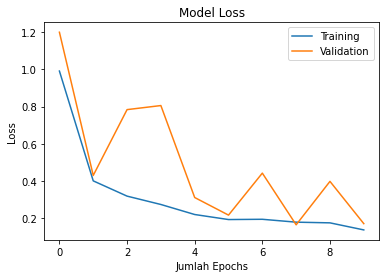

In [20]:
# Menampilkan diagram hasil evaluasi loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Jumlah Epochs')
plt.legend(['Training', 'Validation'])
plt.show()

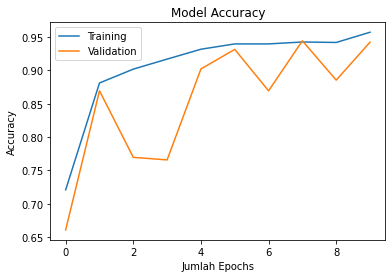

In [21]:
# Menampilkan diagram hasil evaluasi akurasi
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Jumlah Epochs')
plt.legend(['Training', 'Validation'])
plt.show()

In [22]:
model.save('./weed_model_classification.h5')

In [25]:
# Konversi model ke TFlite/Android. 
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Menyimpan model ke TFlite/Android.
with open('./model-for-android.tflite', 'wb') as f:
  f.write(tflite_model)

In [31]:
load_model = load_model('./weed_model_classification.h5')

Saving IMG_20160626_160301.jpg to IMG_20160626_160301.jpg
1/1 [==============================] - 0s 60ms/step
Gambar yang diunggah merupakan jenis gulma: goosefoots


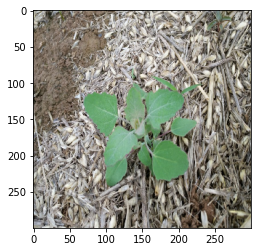

In [36]:
# Menguji model
import keras.utils as image
uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  images = image.load_img(path, target_size=(IMG_SIZE,IMG_SIZE))
  imgplot = plt.imshow(images)
  images_arr = image.img_to_array(images)
  images_arr_expnd = np.expand_dims(images_arr, axis=0)
  images = keras.applications.densenet.preprocess_input(images_arr_expnd) 
  predict = load_model.predict(images)
  result = classes[np.argmax(predict)]
  print("Gambar yang diunggah merupakan jenis gulma:", result)